# Problem Statement

The  data  has  the  following  two  tables:

1. A  user  table  ( "takehome_users" )  with  data  on  12,000  users  who  signed  up  for  the product  in  the  last  two  years.   This  table  includes:


*  name:  the  user's  name
*  object_id:   the  user's  id
*  email:  email  address
*  creation_source:   how  their  account  was  created.  This  takes  on  one of  5  values:
*  PERSONAL_PROJECTS:  invited  to  join  another  user's personal  workspace
*  GUEST_INVITE:  invited  to  an  organization  as  a  guest (limited  permissions)
*  ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
*  SIGNUP:  signed  up  via  the  website
*  SIGNUP_GOOGLE_AUTH:  signed  up  using  Google Authentication  (using  a  Google  email  account  for  their  login
id)
*  creation_time:  when  they  created  their  account
*  last_session_creation_time:   unix  timestamp  of  last  login
*  opted_in_to_mailing_list:  whether  they  have  opted  into  receiving marketing  emails
*  enabled_for_marketing_drip:  whether  they  are  on  the  regular marketing  email  drip
*  org_id:   the  organization  (group  of  users)  they  belong  to
*  invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).



2. A  usage  summary  table  ( "takehome_user_engagement" )  that  has  a  row  for  each  day that  a  user  logged  into  the  product.

Defining  an  **"adopted  user"**   as  a  user  who   has  *logged  into  the  product  on  three  separate
days  in  at  least  one  seven-day  period* ,  identify  which  factors  predict  future  user
adoption .

## EDA

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

In [2]:
plt.rcParams['axes.grid']=True
plt.rcParams["figure.figsize"] = (30,16)

In [3]:
#file is not utf-8 so have to specify encoding
users = pd.read_csv('takehome_users.csv', encoding='latin-1', parse_dates=True)
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
users.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

This dataframe has four string columns and the rest are numerical. There are 12000 user entries with 'last_session_creation_time' and 'invited_by_user_id' containing null values. The former is not relevant to our predictions so we can ignore it however we will need to deal with the latter.

In [6]:
engagement = pd.read_csv('takehome_user_engagement.csv', encoding='latin-1', parse_dates=True, index_col='time_stamp')
engagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [7]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 2 columns):
user_id    207917 non-null int64
visited    207917 non-null int64
dtypes: int64(2)
memory usage: 4.8 MB


In [8]:
engagement.dtypes

user_id    int64
visited    int64
dtype: object

The engagement dataframe only has two columns with over 200,000 logins. There are no missing values.

## Data Cleaning

In [9]:
#getting counts of user logins for every week
agg = engagement.groupby('user_id').resample('1W').sum()
agg.head()

user_id  visited
user_id time_stamp                  
1       2014-04-27        1        1
2       2013-11-17        2        1
        2013-11-24        0        0
        2013-12-01        2        1
        2013-12-08        0        0

In [10]:
#Discarding users that didn't login and dropping extra user id column
df_agg = agg[agg['user_id'].isnull()==False].drop('user_id',axis=1)
df_agg.head(10)

visited
user_id time_stamp         
1       2014-04-27        1
2       2013-11-17        1
        2013-11-24        0
        2013-12-01        1
        2013-12-08        0
        2013-12-15        1
        2013-12-22        0
        2013-12-29        1
        2014-01-05        1
        2014-01-12        1

In [11]:
df_agg.tail(10)

visited
user_id time_stamp         
11991   2014-05-18        1
        2014-05-25        0
        2014-06-01        1
11992   2014-04-13        1
11995   2013-10-27        1
11996   2013-09-08        1
11997   2013-01-20        1
11998   2014-04-27        1
11999   2012-06-03        1
12000   2014-01-26        1

In [12]:
#selecting users that logged in 3 times or more per week 
active = df_agg['visited']>=3

#grouping by users and summing up the weeks that had 3 or more logins
active = active.groupby(level=0).apply(np.sum)

#discards users that didn't have a week with 3 or more visits and saves result into a dataframe
active = active[active!=0]
active_users = pd.DataFrame(active,index=active.index)
active_users.columns = ['active_week']
active_users.head(5)

,active_week
user_id,
2,1
10,52
20,1
33,1
42,68


In [13]:
active_users.tail(5)

,active_week
user_id,
11965,1
11967,8
11969,22
11975,44
11988,6


In [14]:
#merging df with active users who've logged in at least 3 times per week together with df of users
df = active_users.merge(users, left_index=True, right_on='object_id',how='inner')
df.head()

,active_week,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
1,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
9,52,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0
19,1,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN
32,1,33,2014-03-11 06:29:09,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1.401518e+09,0,0,401,79.0
41,68,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN


In [15]:
#create new column in df indicating 1 for users who have been active
df['active'] = 1
df.head()

,active_week,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active
1,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
9,52,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1
19,1,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN,1
32,1,33,2014-03-11 06:29:09,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1.401518e+09,0,0,401,79.0,1
41,68,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN,1


In [16]:
#creating active column in users df indicating whether a user is active (1) or not (0)
users['active'] = int(0)
users.iloc[list(df.index), 10] = 1
data = users.set_index('object_id').sort_index()
data.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active
object_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [17]:
#Will keep 6 columns for final analysis
data = data.drop([ 'name', 'email','last_session_creation_time'], axis=1)
date = data.pop('creation_time')
data.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active
object_id,,,,,,
1,GUEST_INVITE,1,0,11,10803.0,0
2,ORG_INVITE,0,0,1,316.0,1
3,ORG_INVITE,0,0,94,1525.0,0
4,GUEST_INVITE,0,0,1,5151.0,0
5,GUEST_INVITE,0,0,193,5240.0,0


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 6 columns):
creation_source               12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
active                        12000 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 656.2+ KB


In [19]:
#Filling missing values with 0
data['invited_by_user_id'] = data['invited_by_user_id'].fillna(0)

# Assign all other values to 1
data['invited_by_user_id'] = data['invited_by_user_id'].apply(lambda x: 1 if x!=0 else 0)

In [20]:
#labels are imbalanced
data['active'].value_counts()

0    10555
1     1445
Name: active, dtype: int64

In [21]:
# disaggregating creation_source column 
data = pd.get_dummies(data = data, columns = ['creation_source'])
data.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,
1,1,0,11,1,0,1,0,0,0,0
2,0,0,1,1,1,0,1,0,0,0
3,0,0,94,1,0,0,1,0,0,0
4,0,0,1,1,0,1,0,0,0,0
5,0,0,193,1,0,1,0,0,0,0


In [22]:
#disaggregating org_id column
organisation = data.groupby('org_id').sum()

org_category = []
for i in data['org_id']:
    category = organisation.loc[i,'active']
    org_category.append(category)
data['org_id'] = org_category

data = pd.get_dummies(data = data, columns = ['org_id'])

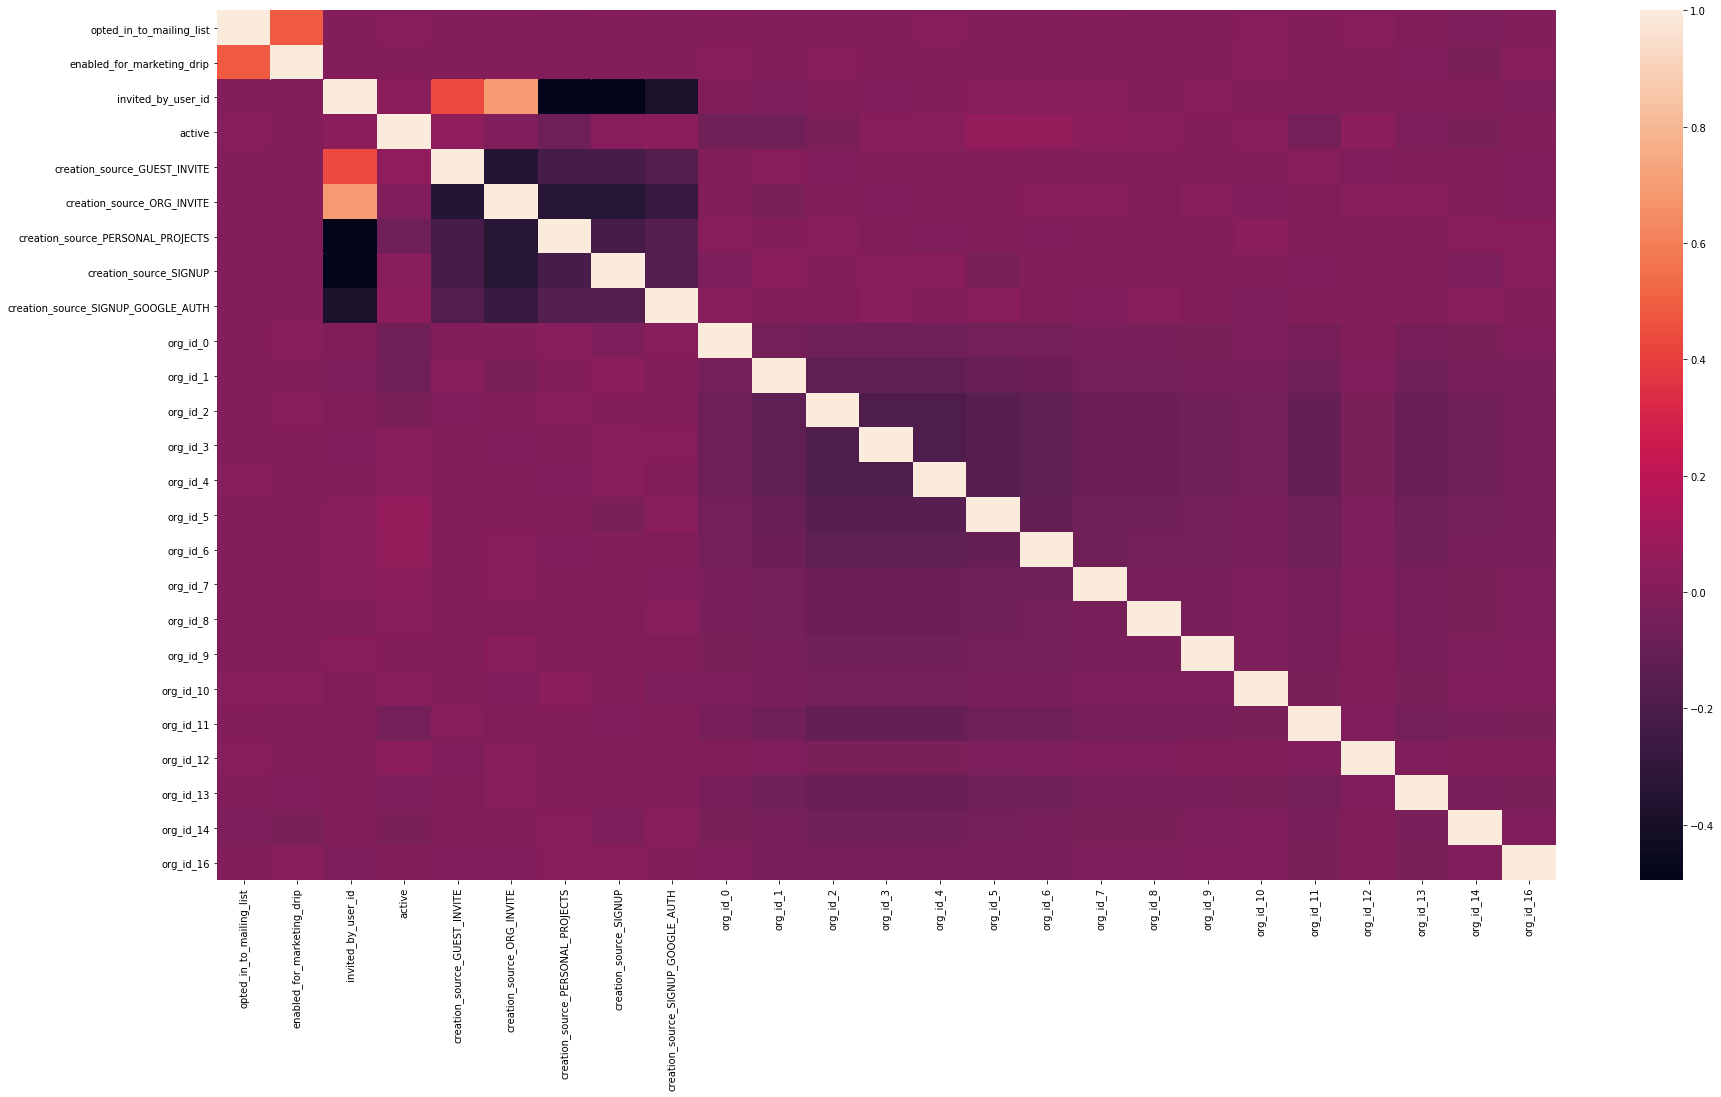

In [23]:
# heat map showing most correlated columns with 'active' column
fig = plt.figure()
ax = plt.subplot(111)
corr = data.corr()
ax = sns.heatmap(corr)
plt.show()

In [24]:
corr['active'].sort_values(ascending=False)

active                                1.000000
org_id_5                              0.059582
org_id_6                              0.057128
creation_source_GUEST_INVITE          0.043657
org_id_12                             0.032859
creation_source_SIGNUP_GOOGLE_AUTH    0.031432
invited_by_user_id                    0.022735
org_id_7                              0.021869
org_id_4                              0.016279
creation_source_SIGNUP                0.016004
opted_in_to_mailing_list              0.010339
org_id_3                              0.007948
org_id_8                              0.007735
org_id_10                             0.007492
enabled_for_marketing_drip            0.005901
org_id_16                             0.004317
org_id_9                              0.002004
creation_source_ORG_INVITE           -0.011376
org_id_13                            -0.019385
org_id_2                             -0.023874
org_id_14                            -0.026086
org_id_11    

The wrangled dataframe has labels in the 'active' column with 0 representing an inactive user while 1 represents an active user. This column is heavily imbalanced with the majority of users marked 0 (inactive). The features which have a high correlation with the 'active' column are org_id_5, org_id_6, creation_source_GUEST_INVITE, org_id_12, and creation_source_SIGNUP_GOOGLE_AUTH. Of these five features, the most intuitive ones are creation_source_GUEST_INVITE and creation_source_SIGNUP_GOOGLE_AUTH. The first one makes sense because most people have a higher likelihood of using a service recommended by a person they trust. The second one also makes sense due to the ease of logging in with one's Google credentials, therefore negating the need to setup new passwords. Organizations 5, 6, and 12 might require their employees to use the service which might explain the high usage levels. 

In [25]:
#Evaluation of wrangled dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 25 columns):
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
invited_by_user_id                    12000 non-null int64
active                                12000 non-null int64
creation_source_GUEST_INVITE          12000 non-null uint8
creation_source_ORG_INVITE            12000 non-null uint8
creation_source_PERSONAL_PROJECTS     12000 non-null uint8
creation_source_SIGNUP                12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    12000 non-null uint8
org_id_0                              12000 non-null uint8
org_id_1                              12000 non-null uint8
org_id_2                              12000 non-null uint8
org_id_3                              12000 non-null uint8
org_id_4                              12000 non-null uint8
org_id_5                              12000 non-null uint8
org_id

In [26]:
#splitting the data into train and test sets
data = data.astype('int')
y = data['active']
X = data.drop('active', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((8400, 24), (3600, 24), (8400,), (3600,))

# Random Forest Classifier

In [28]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [29]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8777777777777778


In [30]:
print(metrics.classification_report(y_test, y_pred, target_names=['active','inactive']))


              precision    recall  f1-score   support

      active       0.88      1.00      0.93      3169
    inactive       0.20      0.01      0.01       431

   micro avg       0.88      0.88      0.88      3600
   macro avg       0.54      0.50      0.47      3600
weighted avg       0.80      0.88      0.82      3600



In [31]:
print(metrics.confusion_matrix(y_test, y_pred))


[[3157   12]
 [ 428    3]]


The classifier does much better predicting true positives versus true negatives which is reflected by the high accuracy of 88% with an F1-score of 47%. This is a reflection of the heavy imbalance in the labels of the original dataframe. 

# Tuned RF

In [32]:
param = {'n_estimators' : [40, 50, 100, 150, 200, 250, 300, 500, 1000],
        'max_depth': [8, 10, 12, 14, 16, 18, 20]}

clf1 = RandomForestClassifier()

clf1_cv = RandomizedSearchCV(clf1, param_distributions=param, cv=5)
clf1_cv.fit(X_train, y_train)
print("Tuned Model Parameters: {}".format(clf1_cv.best_params_))

Tuned Model Parameters: {'n_estimators': 150, 'max_depth': 8}


In [33]:
clf1 = RandomForestClassifier(n_estimators=150, max_depth=8)
clf1.fit(X_train, y_train)
y_pred1 = clf.predict(X_test) 


In [34]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred1))

Accuracy: 0.8777777777777778


In [35]:
print(metrics.classification_report(y_test, y_pred1, target_names=['active','inactive']))

              precision    recall  f1-score   support

      active       0.88      1.00      0.93      3169
    inactive       0.20      0.01      0.01       431

   micro avg       0.88      0.88      0.88      3600
   macro avg       0.54      0.50      0.47      3600
weighted avg       0.80      0.88      0.82      3600



In [36]:
print(metrics.confusion_matrix(y_test, y_pred1))


[[3157   12]
 [ 428    3]]


The tuned forest doesn't perform that much better over the untuned forest for both F1 score and accuracy. This is a reflection of the underlying data quality. 

# Gradient Boosting Classifier

In [37]:
gbc = GradientBoostingClassifier(max_features='sqrt', random_state=42)

gbc.fit(X_train, y_train)
y_pred2 = gbc.predict(X_test)

In [38]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))

Accuracy: 0.8802777777777778


In [39]:
print(metrics.classification_report(y_test, y_pred2, target_names=['active','inactive']))

              precision    recall  f1-score   support

      active       0.88      1.00      0.94      3169
    inactive       0.00      0.00      0.00       431

   micro avg       0.88      0.88      0.88      3600
   macro avg       0.44      0.50      0.47      3600
weighted avg       0.77      0.88      0.82      3600



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
print(metrics.confusion_matrix(y_test, y_pred2))

[[3169    0]
 [ 431    0]]


The Gradient Boosting Classifier has a small advantage over the Random Forest when it comes to the accuracy but the F1 score does not improve. This is a reflection of the severe imbalance in the labels.

# Tuned Gradient Boosting Classifier

In [42]:
parameters = {'n_estimators':[40,45,50,55,60],'learning_rate':[.01,0.02,0.03,0.04,0.05],
              'max_depth':[1,2,3,4,5]}

gbc1 = GradientBoostingClassifier(max_features='sqrt', random_state=42)
gbc1_cv = RandomizedSearchCV(gbc1, param_distributions=parameters, cv=5)

gbc1_cv.fit(X_train, y_train)
print("Tuned Model Parameters: {}".format(gbc1_cv.best_params_))

Tuned Model Parameters: {'n_estimators': 40, 'max_depth': 1, 'learning_rate': 0.05}


In [43]:
gbc1 = GradientBoostingClassifier(max_features='sqrt', random_state=42, n_estimators=40, max_depth=1, learning_rate=0.05)
gbc1.fit(X_train, y_train)
y_pred3 = gbc1.predict(X_test)


In [44]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred3))

Accuracy: 0.8802777777777778


In [45]:
print(metrics.classification_report(y_test, y_pred3, target_names=['active','inactive']))

              precision    recall  f1-score   support

      active       0.88      1.00      0.94      3169
    inactive       0.00      0.00      0.00       431

   micro avg       0.88      0.88      0.88      3600
   macro avg       0.44      0.50      0.47      3600
weighted avg       0.77      0.88      0.82      3600



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
print(metrics.confusion_matrix(y_test, y_pred3))

[[3169    0]
 [ 431    0]]


Tuning does not improve the GBC's performance but we will use it to find the most important features below.

# Most Important Features - Gradient Boosting Classifier

Text(0.5, 1.0, 'Gradient Boosting Classifier Feature Importance')

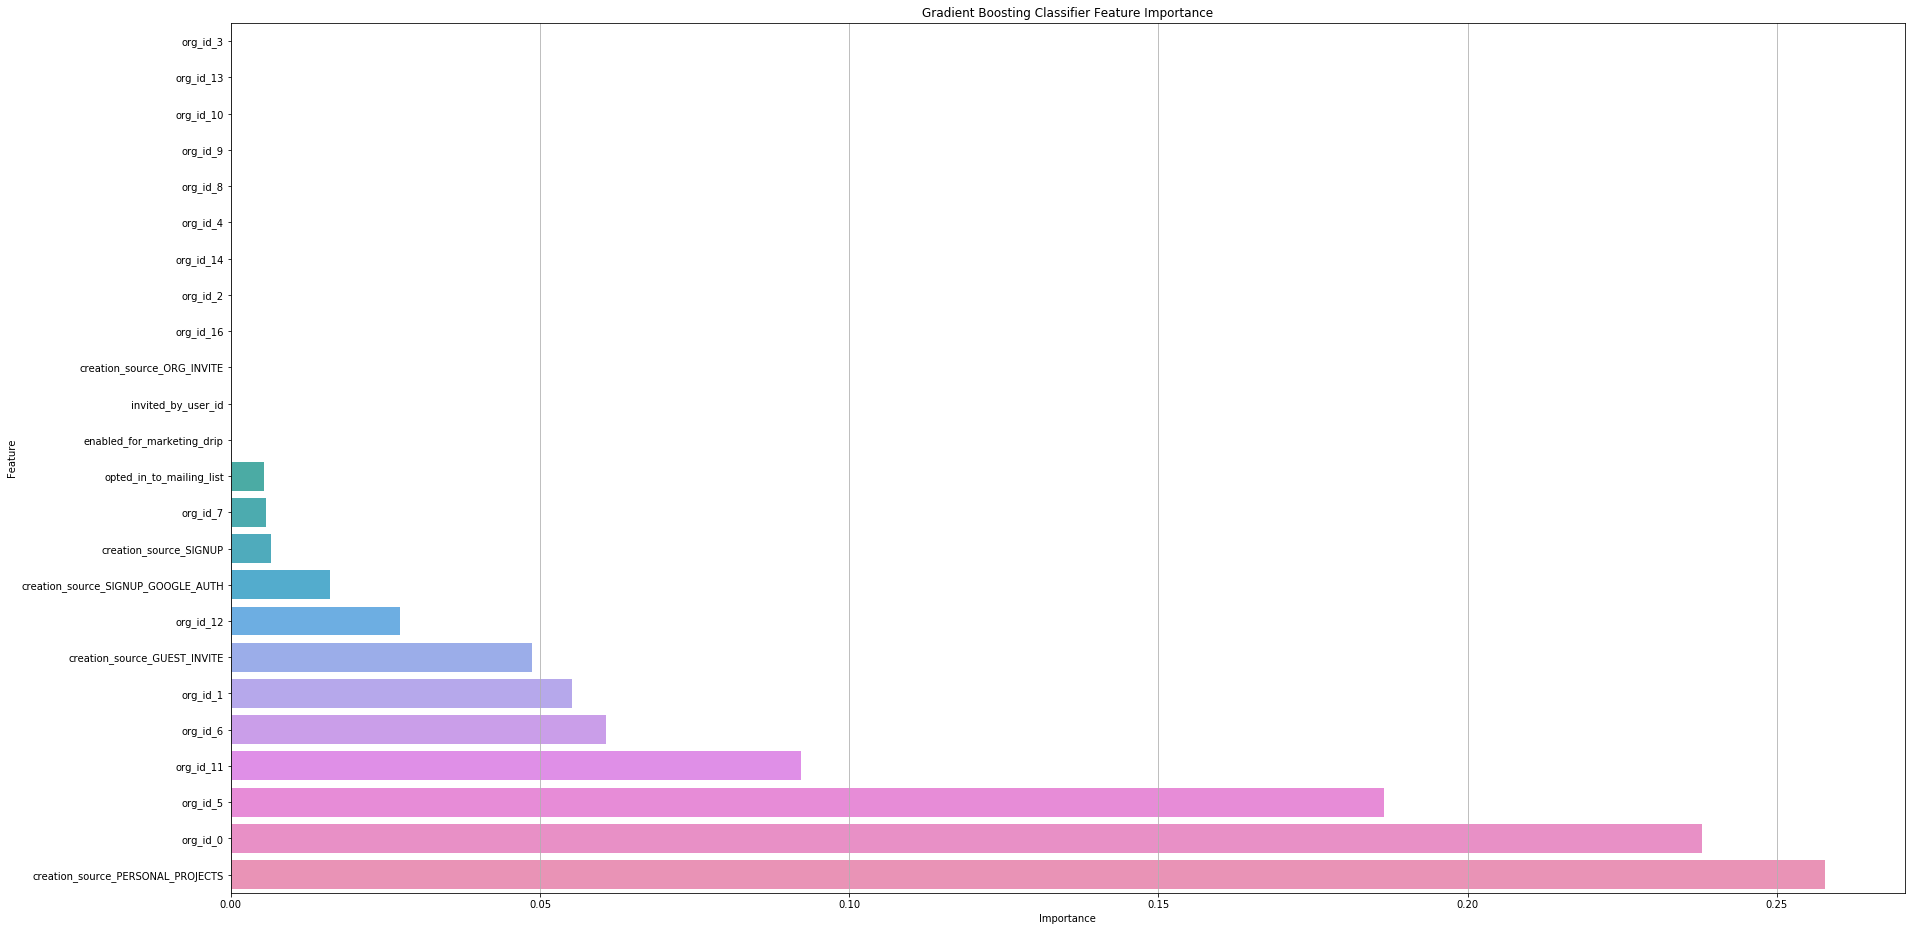

In [47]:
features = pd.DataFrame({'Importance': gbc1.feature_importances_})    
features['Feature'] = X.columns
features.sort_values(by='Importance', ascending=True, inplace=True)

ax1= sns.barplot(y="Feature", x="Importance", data=features)
ax1.set_title('Gradient Boosting Classifier Feature Importance')

In [48]:
for name, importance in zip(X_train.columns, gbc1.feature_importances_):
    print(name, "=", importance)

opted_in_to_mailing_list = 0.005324365683512106
enabled_for_marketing_drip = 0.0
invited_by_user_id = 0.0
creation_source_GUEST_INVITE = 0.04865496395150403
creation_source_ORG_INVITE = 0.0
creation_source_PERSONAL_PROJECTS = 0.25782382602115766
creation_source_SIGNUP = 0.006561251130366034
creation_source_SIGNUP_GOOGLE_AUTH = 0.01607918507454285
org_id_0 = 0.23788968575859598
org_id_1 = 0.055143342518376735
org_id_2 = 0.0
org_id_3 = 0.0
org_id_4 = 0.0
org_id_5 = 0.1865013100625865
org_id_6 = 0.06063005787582326
org_id_7 = 0.005764307744742145
org_id_8 = 0.0
org_id_9 = 0.0
org_id_10 = 0.0
org_id_11 = 0.09228289000658335
org_id_12 = 0.02734481417220922
org_id_13 = 0.0
org_id_14 = 0.0
org_id_16 = 0.0


# Conclusion

The top 5 most important features are creation_source_PERSONAL_PROJECTS, org_id_0, org_id_5, org_id_11 and org_id_6. As mentioned previously, the organizations might require their employees to use the service which could drive increased retention rates. Users who interact with the service for a personal project might also have low attrition rates because they're motivated by their project. 